In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Rose', 'habituation2'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 2745.30 seconds 
duration: 0.76 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 11.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,29.9300,30.4324,,0.5024
1,307.6444,308.2116,,0.5672
2,423.4812,423.9852,,0.5040
3,1284.8556,1290.1612,,5.3056
4,1627.3924,1627.9908,,0.5984
5,1712.3548,1713.0612,,0.7064
6,1878.7924,1879.4380,,0.6456
7,2303.7188,2304.2220,,0.5032
8,2311.9708,2312.4772,,0.5064
9,2318.2876,2318.7908,,0.5032


<Axes: >

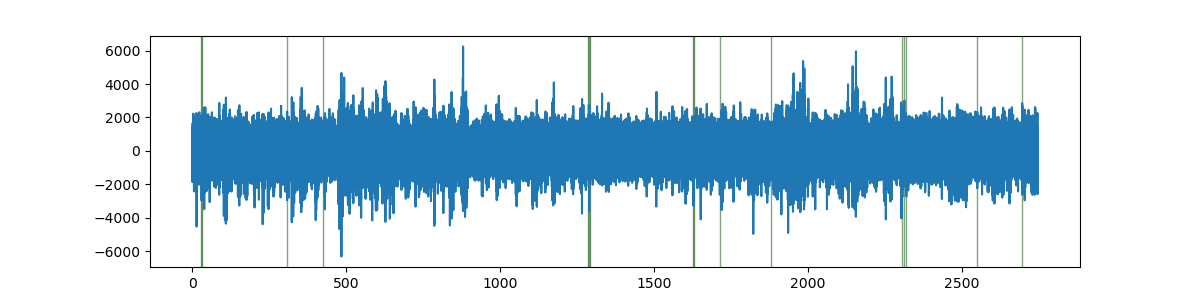

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.probegroup.npy saved


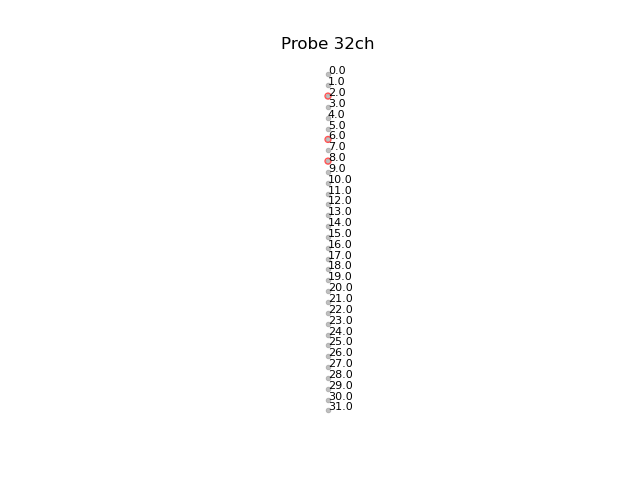

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 24
# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [24]
189 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.theta_epochs.npy saved


## Detect SWR Epochs

In [9]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 24
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [24]
2441 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.ripple_epochs.npy saved


## Detect Delta

In [10]:
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 24

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal

delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)
sess.recinfo.write_epochs(delta_epochs, ext='dta')
delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs.save(delta_epochs_file)

930 delta waves detected
/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.delta_epochs.npy saved


In [11]:
#Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 24
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(beta_epochs, ext='bta')
beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs.save(beta_epochs_file)

Best channel for beta: [24]
191 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.beta_epochs.npy saved


In [12]:
# Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 0.5 
highthresh = 5
minDistance = 20
minDuration = 1
gamma_channel = 24

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
sess.recinfo.write_epochs(gamma_epochs, ext='gma')
gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs.save(gamma_epochs_file)

/data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_denoised.gamma_epochs.npy saved


# Wavelet Analysis

### Start with Theta

In [13]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

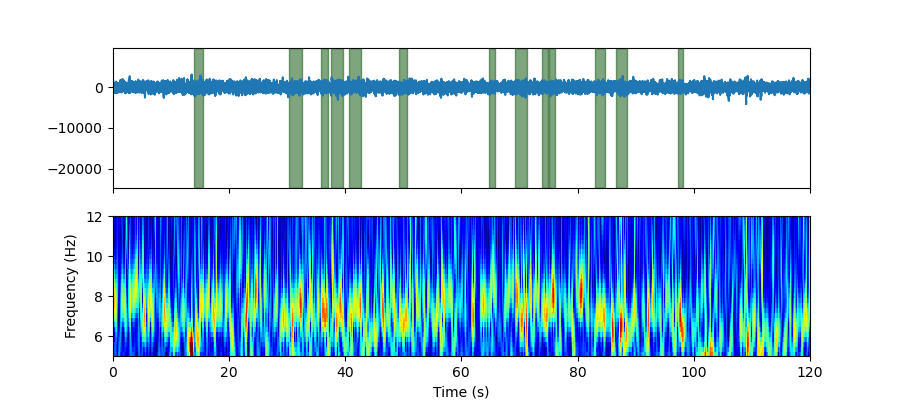

In [14]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

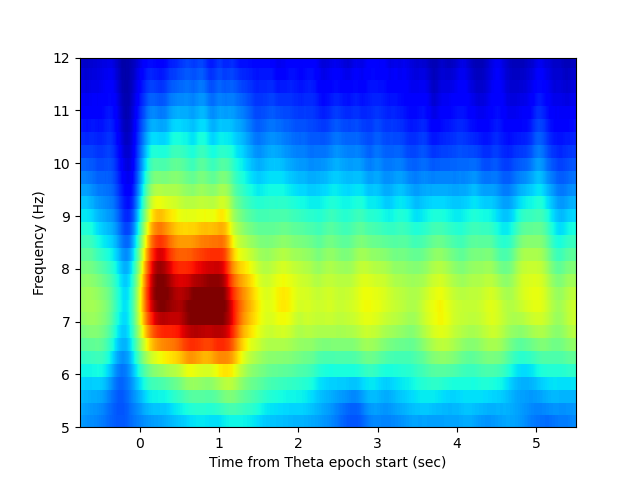

In [15]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [16]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

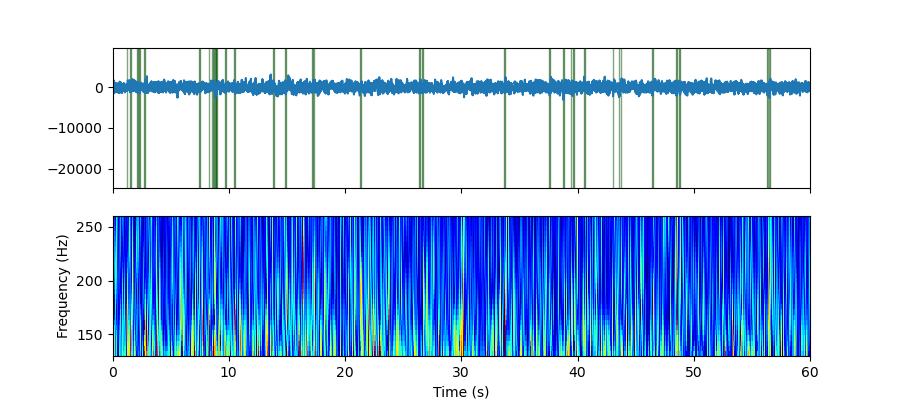

In [17]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Delta

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

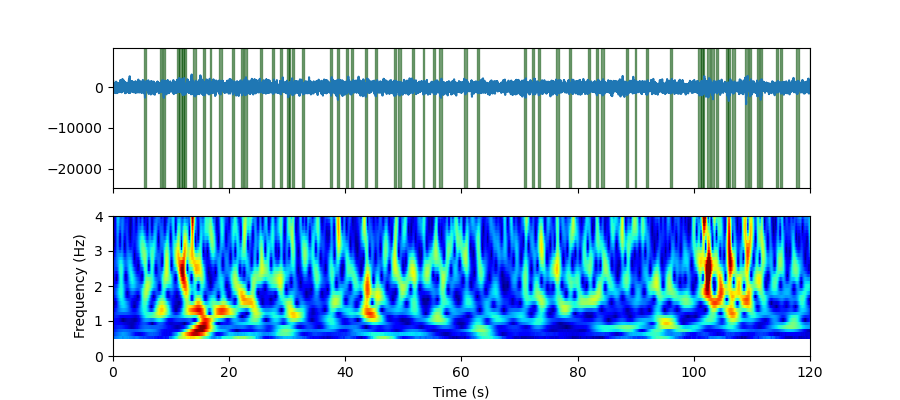

In [18]:
delta_range = np.arange(0.5, 4.25, 0.1)
wv_delta = WaveletSg(signal.time_slice(channel_id=delta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=delta_range, sigma=None)
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
delta_freq_lims = [0.5, 4]

plot_signal_w_epochs(signal, delta_channel, delta_epochs, ax=ax[0])

plot_spectrogram(wv_delta, time_lims=time_to_plot, freq_lims=delta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

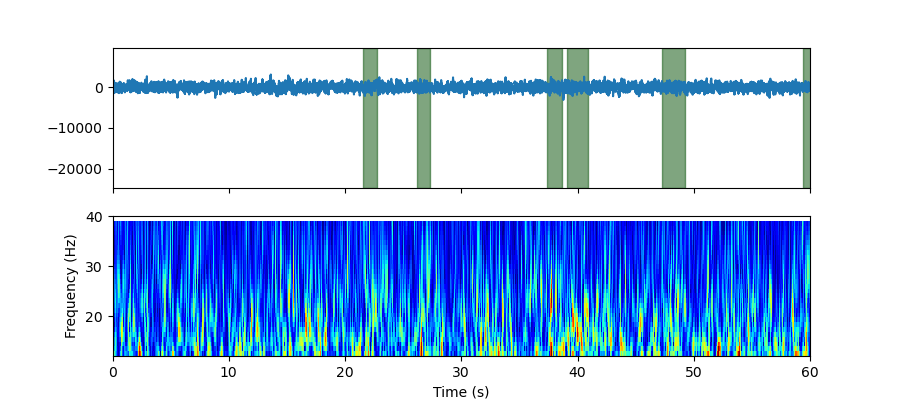

In [19]:
## Beta
beta_range = np.arange(12, 40, 1)  # How do I select these? 
wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=beta_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
beta_freq_lims = [12, 40]

plot_signal_w_epochs(signal, beta_channel, beta_epochs, ax=ax[0])

plot_spectrogram(wv_beta, time_lims=time_to_plot, freq_lims=beta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

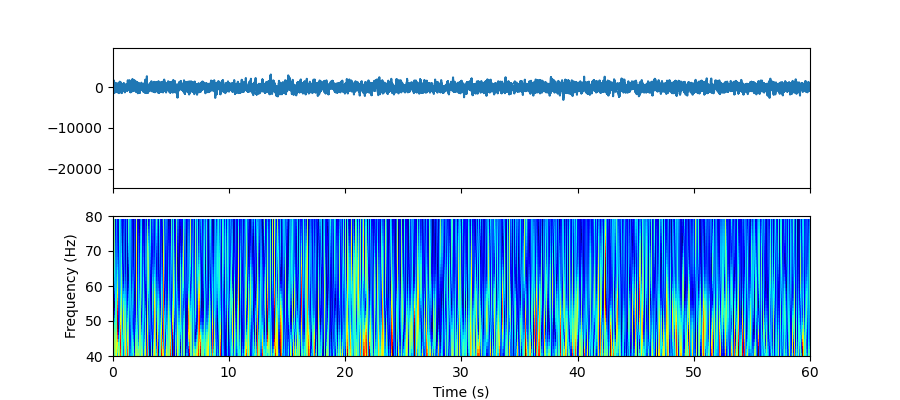

In [20]:
#gamma
gamma_range = np.arange(40, 80, 1)
wv_gamma = WaveletSg(signal.time_slice(channel_id=gamma_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=gamma_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
gamma_freq_lims = [40, 80]

plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])

plot_spectrogram(wv_gamma, time_lims=time_to_plot, freq_lims=gamma_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

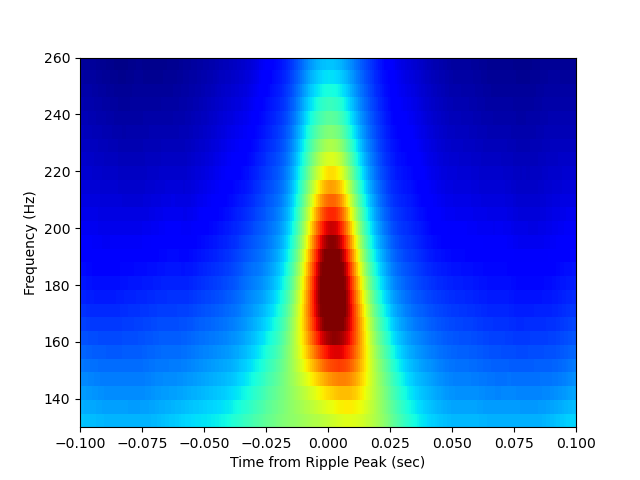

In [21]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-USV analyses

In [22]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


22 epochs
Snippet: 
        start       stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  21.903809  21.940337    2.816586  37.352376  0.036534   14.403846      1   
1  23.099961  23.159905    4.012934  43.041290  0.059953   27.113122      1   
2  28.500217  28.552668    9.414074  42.920249  0.052459    9.320136      1   
3  29.415290  29.464931   10.329296  42.194005  0.049649   10.772624      1   
4  64.723776  64.783719   45.643560  40.015271  0.059953   23.845023      1   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

In [23]:
usv_epochs._epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,21.903809,21.940337,2.816586,37.352376,0.036534,14.403846,1,1,
1,23.099961,23.159905,4.012934,43.041290,0.059953,27.113122,1,1,
2,28.500217,28.552668,9.414074,42.920249,0.052459,9.320136,1,1,
3,29.415290,29.464931,10.329296,42.194005,0.049649,10.772624,1,1,
4,64.723776,64.783719,45.643560,40.015271,0.059953,23.845023,1,1,
5,76.083041,76.143921,57.004684,38.078620,0.060890,14.040724,1,1,
6,83.298254,83.360539,64.221077,42.557127,0.062295,25.781674,1,1,
7,85.160891,85.220835,66.084020,41.467760,0.059953,23.481900,1,1,
8,96.992141,97.053021,77.917205,43.404412,0.060890,12.225113,1,1,
9,143.624214,143.679474,124.556909,41.830882,0.055269,10.046380,1,1,


In [24]:
usv_epochs._epochs.Duration.mean()

0.048878449110436734

In [25]:
short_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Duration<0.1]
short_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,21.903809,21.940337,2.816586,37.352376,0.036534,14.403846,1,1,
1,23.099961,23.159905,4.012934,43.041290,0.059953,27.113122,1,1,
2,28.500217,28.552668,9.414074,42.920249,0.052459,9.320136,1,1,
3,29.415290,29.464931,10.329296,42.194005,0.049649,10.772624,1,1,
4,64.723776,64.783719,45.643560,40.015271,0.059953,23.845023,1,1,
5,76.083041,76.143921,57.004684,38.078620,0.060890,14.040724,1,1,
6,83.298254,83.360539,64.221077,42.557127,0.062295,25.781674,1,1,
7,85.160891,85.220835,66.084020,41.467760,0.059953,23.481900,1,1,
8,96.992141,97.053021,77.917205,43.404412,0.060890,12.225113,1,1,
9,143.624214,143.679474,124.556909,41.830882,0.055269,10.046380,1,1,


## Theta mean spectrogram

628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
709 frames between 307.6 and 308.2 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start(sec)')

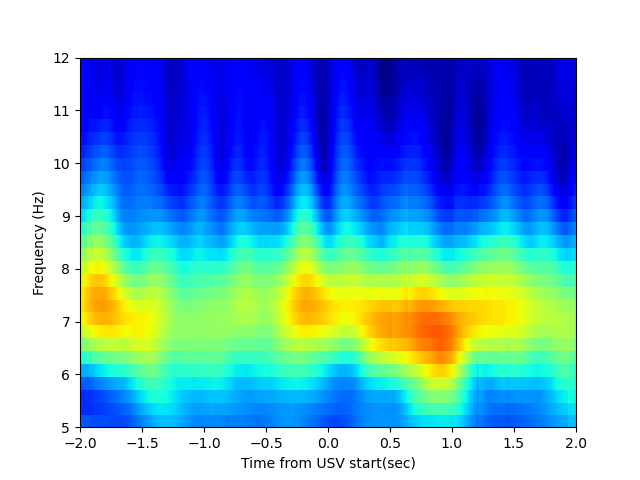

In [25]:
# Example code to plot theta at USV starts
usv_buffer_sec = (2, 2)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Ripple mean spectrogram

628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
709 frames between 307.6 and 308.2 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

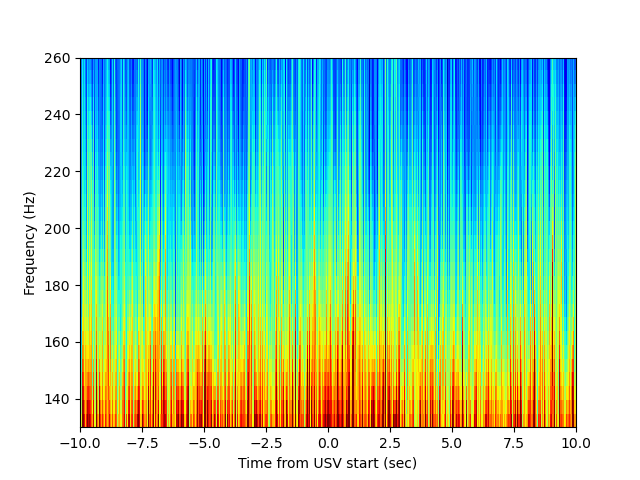

In [27]:
# All
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Delta

628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
709 frames between 307.6 and 308.2 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

Text(0.5, 0, 'Time from USV start(sec)')

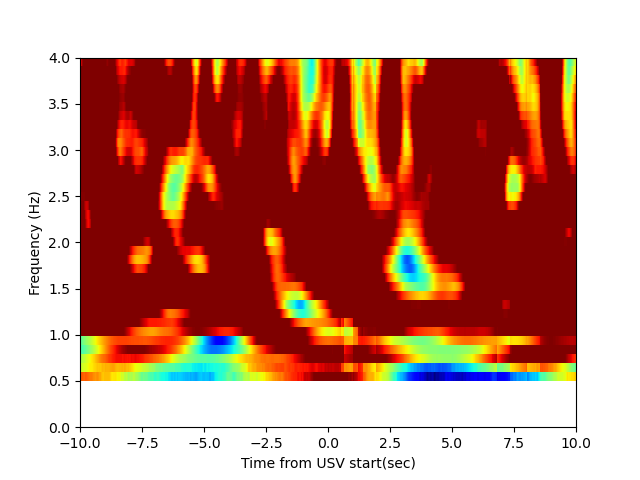

In [28]:
#Delta
usv_buffer_sec = (10, 10)
wv_delta_mean = wv_delta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
709 frames between 307.6 and 308.2 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

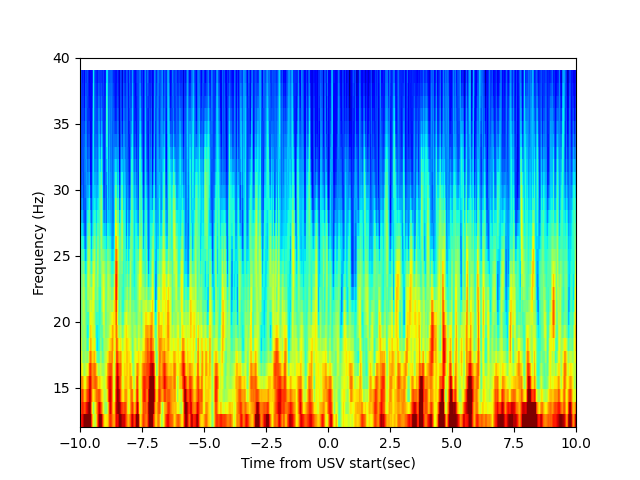

In [30]:
#Beta
usv_buffer_sec = (10, 10)
wv_beta_mean = wv_beta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

628 frames between 29.9 and 30.4 ignored (sent to nan)
628 frames between 29.9 and 30.4 ignored (sent to nan)
709 frames between 307.6 and 308.2 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start(sec)')

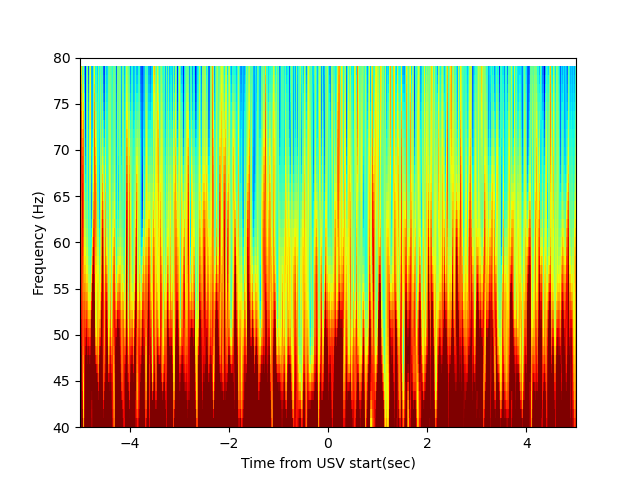

In [32]:
#Gamma
usv_buffer_sec = (5, 5)
wv_gamma_mean = wv_gamma.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_gamma_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=gamma_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Finn recall7 note:
pyr channel (26) has weird-looking oscillations particularly during CS- and CS+(2) times.  I have used channel 20 instead which is well above the cell layer but has good-looking volume-conducted theta.  SWR detection appears to be fine using ch 26.

## Save notebook to working directory

In [33]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Animal_files/USV_Spectral_Analysis(Rose_habituation2).ipynb saved to /data2/Trace_FC/Recording_Rats/Rose/2022_06_21_habituation2/Rose_habituation2_USV_Spectral_Analysis(Rose_habituation2).ipynb


In [34]:
pip install jupyter-save-load-vars

Note: you may need to restart the kernel to use updated packages.
